























































# Proyecto
Cristian Leilael Rico Espinosa

Matrícula: A01707023

Proyecto para el Módulo 2 de "Desarrollo de aplicaciones avanzadas de ciencias computacionales". En este se realizará un modelo el cual se entrenará con imágenes de paisajes para que, posteriormente, pueda identificar imágenes pertenecientes a estos.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


base_dir = '.\\Model\\images\\'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

## Preprocesado de Datos

Se comienza con la carga y preprocesamiento de imágenes desde directorios.

El tratamiento va desde el escalando sus valores de píxeles al rango de 0 a 1 para hasta ediciones de las mismas que van desde rotar hasta hacer un poco de zoom en las mismas.

En los *generators* también se edita el tamaño de las imágenes para que estas puedan ser utilizadas rápidamente en el entranamiento y las pruebas del modelo. De igual forma, elegir un *class_mode* ***"categorical"*** le permitirá al modelo generar etiquetas para las clases, en este caso para cada uno de los paisajes para que esto pueda facilitar el entrenamiento.

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size= 32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size= 32,
    class_mode='categorical'
)

Found 8400 images belonging to 5 classes.
Found 2100 images belonging to 5 classes.


### Imágenes de *Train*

Para comprobar si la conversión se hizo adecuadamente, se utiliza *plot* para mostrar visualizaciones de algunas de las imágenes.

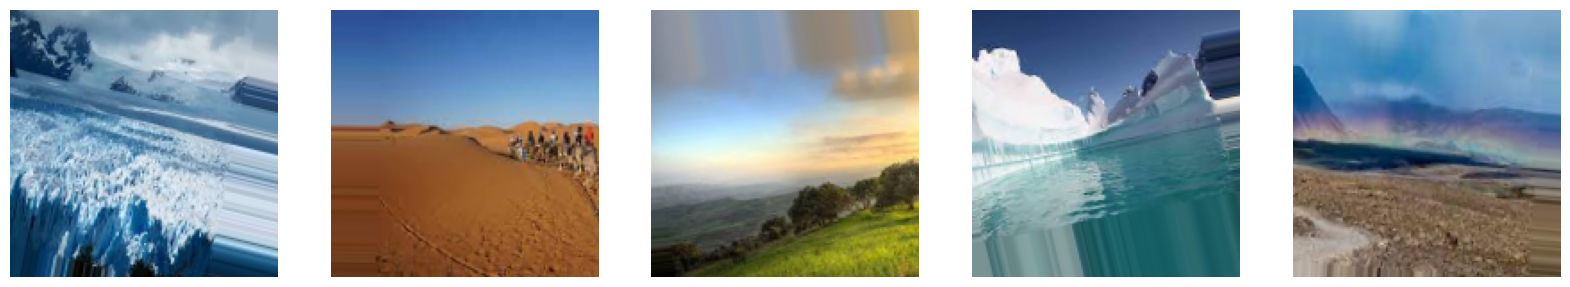

In [3]:
plt.figure(figsize=(20, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    batch = next(train_generator)
    image = batch[0][0]
    plt.imshow(image)
    plt.axis('off')
plt.show()

### Imágenes de *Test*

Para comprobar si la conversión se hizo adecuadamente, se utiliza *plot* para mostrar visualizaciones de algunas de las imágenes.

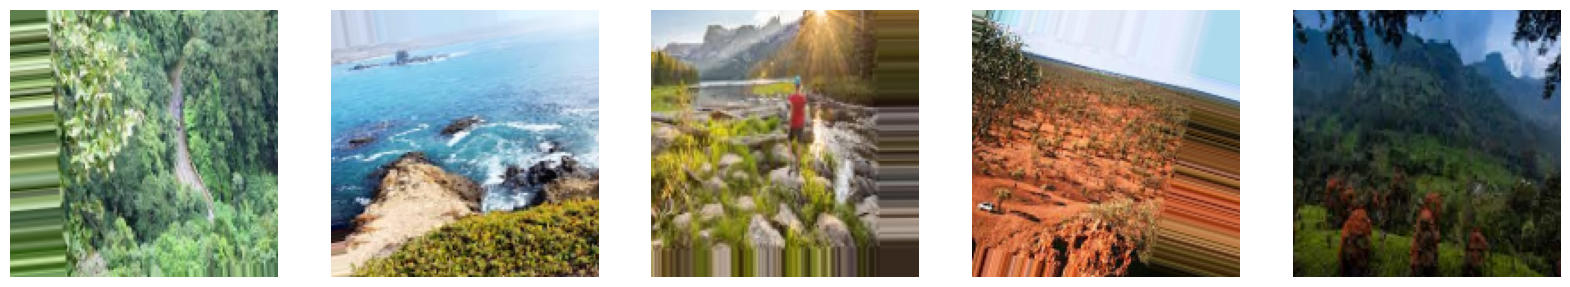

In [4]:
plt.figure(figsize=(20, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    batch = next(test_generator)
    image = batch[0][0]
    plt.imshow(image)
    plt.axis('off')
plt.show()

## Creación del Modelo
Para este modelo se decidió utilizar la arquitectura de ***InceptionV3*** sin incluir la capa del modelo original al querer que entrene en capas personalizadas.

Posterior a especificar que el modelo será secuencial y agregar el modelo base que contiene a ***InceptionV3***, se tiene lo siguiente:

1. Capa de reducción de dimensionalidad global: Se agrega una capa de GlobalAveragePooling2D que reduce la dimensionalidad de las características extraídas de la base InceptionV3 a través de un promedio global.
2. Capa *dense*: Posee 256 neuronas y activación ReLU.
3. Capa de salida: Se agrega una capa densa final con 5 neuronas (correspondientes a las 5 clases de salida) y activación softmax. Esto genera una distribución de probabilidad sobre las clases, indicando la probabilidad de que una imagen pertenezca a cada clase.

La decisión por utilizar ***InceptionV3*** se hizo por su gran capacidad para identificar correctamente los elementos que pertenecen a cada clase.

In [5]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False


# En caso de requerir fine tune, cambiar trainable a true
# fine_tune_at = 100


# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False


model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [6]:
history = model.fit(
    train_generator,
    # steps_per_epoch=200,
    epochs=50
)

acc = history.history['acc']
loss = history.history['loss']

model.save('4thrun.keras')

Epoch 1/50


c:\Users\crisb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


263/263 ━━━━━━━━━━━━━━━━━━━━ 96s 337ms/step - acc: 0.2889 - loss: 0.5511
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 89s 336ms/step - acc: 0.5578 - loss: 0.4099
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 89s 334ms/step - acc: 0.6362 - loss: 0.3535
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 333ms/step - acc: 0.6719 - loss: 0.3276
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 333ms/step - acc: 0.7033 - loss: 0.3072
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 333ms/step - acc: 0.7140 - loss: 0.2932
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 330ms/step - acc: 0.7164 - loss: 0.2974
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 89s 333ms/step - acc: 0.7165 - loss: 0.2834
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 90s 337ms/step - acc: 0.7288 - loss: 0.2788
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 330ms/step - acc: 0.7331 - loss: 0.2729
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 332ms/step - acc: 0.7419 - loss: 0.2662
Epoch 12/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 331ms/step - acc: 0.7465 - loss: 0.2580


<Figure size 640x480 with 0 Axes>

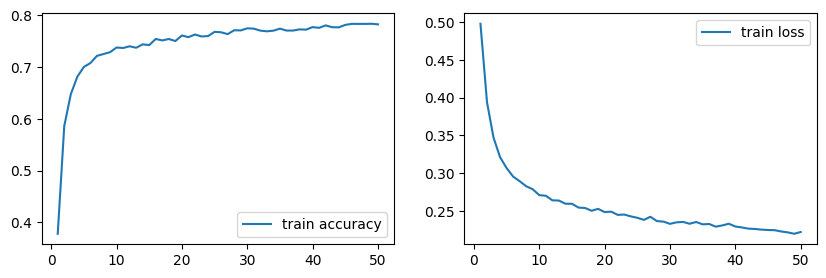

In [7]:
epochs = range(1, len(acc)+1)

plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2, figsize=(10, 3))
axarr[0].plot(epochs,acc,label='train accuracy')
axarr[0].legend()
axarr[1].plot(epochs,loss,label='train loss')
axarr[1].legend()

In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print('\ntest acc :\n', test_acc)

predictions = model.predict(test_generator)
predict_class = (predictions > 0.5).astype("int32")
predict_class.shape


66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 344ms/step - acc: 0.7709 - loss: 0.2417

test acc :
 0.7699999809265137
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 332ms/step


(2100, 5)

### Comparación de Resultados

In [9]:
test_imgs = test_generator[0][0]
test_labels = test_generator[0][1]


predictions = model.predict(test_imgs)
classes_x = np.argmax(predictions,axis=1)
classes_x

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([1, 4, 3, 4, 3, 3, 0, 1, 4, 2, 1, 4, 2, 0, 2, 3, 1, 3, 2, 3, 4, 3,
       3, 1, 1, 2, 4, 2, 1, 4, 2, 3], dtype=int64)

### Matriz de Confusión
Haciendo uso de *seaborn* para generar un mapa de calor, se puede observar que el modelo puede identificar el contenido de una de las clases, usualmente mejor en unas que en otras.

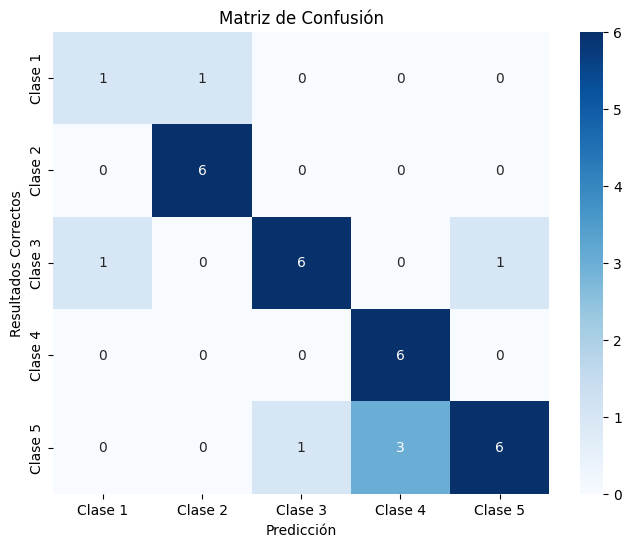

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Resultados reales
true_labels = np.argmax(test_labels, axis=1)

# Predicciones hechas por el modelo
predicted_labels = np.argmax(predictions, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5"], yticklabels=["Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5"])
plt.xlabel('Predicción')
plt.ylabel('Resultados Correctos')
plt.title('Matriz de Confusión')
plt.show()